# Notebook 06: Stress Period Analysis and Value-at-Risk (VaR)

**Objective:**  
- Analyze volatility forecasts during stress periods  
- Demonstrate the limitations of backward-looking risk measures  
- Extend GARCH volatility forecasts to Value-at-Risk (VaR)  
- Illustrate practical market risk applications  

**Asset:** NIFTY 50 Index  
**Frequency:** Daily  


In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 15.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from arch import arch_model
from scipy.stats import norm


In [7]:
ticker = "^NSEI"

df = yf.download(
    ticker,
    start="2015-01-01",
    end="2024-12-31",
    progress=False
)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[["Close"]].rename(columns={"Close": "Price"})
df["log_return"] = np.log(df["Price"] / df["Price"].shift(1))
returns = df["log_return"].dropna()

# Scale returns for numerical stability
returns_scaled = 100 * returns


/tmp/ipython-input-1277735455.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


In [8]:
garch = arch_model(
    returns_scaled,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

garch_res = garch.fit(disp="off")


In [9]:
# Conditional volatility (convert back to return scale)
garch_vol = garch_res.conditional_volatility / 100

# Rolling historical volatility (30-day window)
rolling_vol = returns.rolling(window=30).std()


In [10]:
stress_df = pd.DataFrame({
    "Returns": returns,
    "GARCH_Vol": garch_vol,
    "Rolling_Vol": rolling_vol
}).loc["2020-02-01":"2020-06-30"].dropna()

stress_df.head()


,Returns,GARCH_Vol,Rolling_Vol
Date,,,
2020-02-03,-0.021479,0.007823,0.008085
2020-02-04,0.022946,0.010481,0.009242
2020-02-05,0.009099,0.012323,0.009394
2020-02-06,0.004029,0.011893,0.009334
2020-02-07,-0.003268,0.011222,0.009166


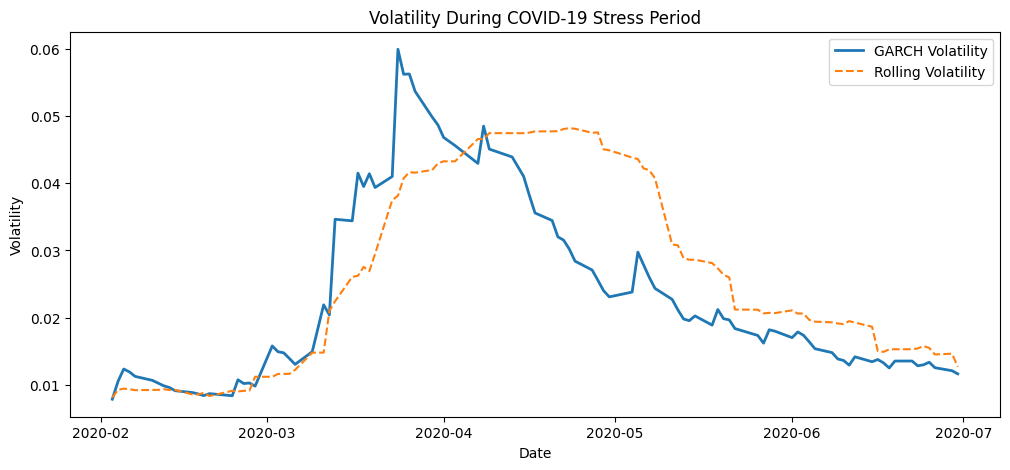

In [15]:
plt.figure(figsize=(12,5))
plt.plot(stress_df["GARCH_Vol"], label="GARCH Volatility", linewidth=2)
plt.plot(stress_df["Rolling_Vol"], label="Rolling Volatility", linestyle="--")
plt.title("Volatility During COVID-19 Stress Period")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Stress Period Interpretation

During the COVID-19 market stress period, rolling historical volatility reacts
with a noticeable lag, underestimating risk during the early phase of the crisis.
In contrast, GARCH-based volatility adjusts immediately to new shocks, providing
a more realistic and timely assessment of market risk under extreme conditions.


In [12]:
alpha = 0.99
z_alpha = norm.ppf(alpha)

var_99 = z_alpha * garch_vol


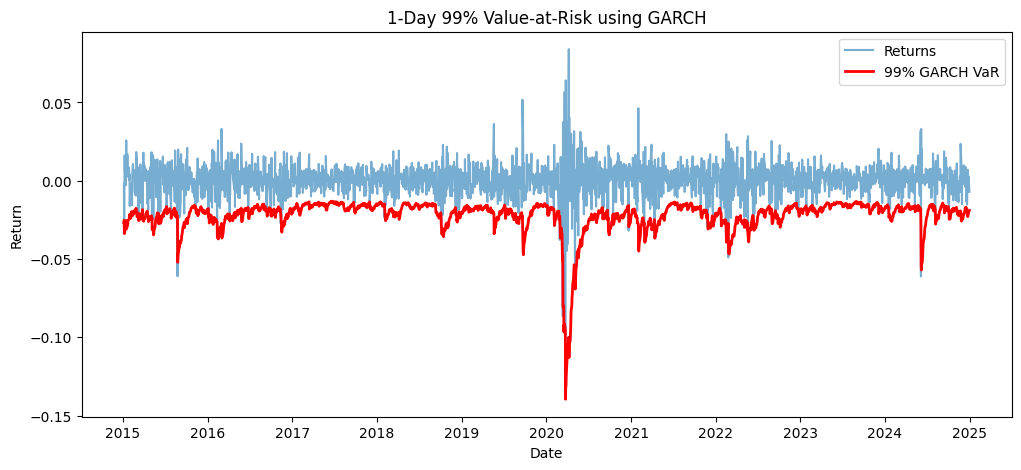

In [13]:
plt.figure(figsize=(12,5))
plt.plot(returns, label="Returns", alpha=0.6)
plt.plot(-var_99, label="99% GARCH VaR", color="red", linewidth=2)
plt.title("1-Day 99% Value-at-Risk using GARCH")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()


In [20]:
exceptions = returns < -var_99
exception_rate = exceptions.mean()

float(exception_rate)


0.017501017501017502

### VaR Interpretation

The GARCH-based 99% Value-at-Risk closely tracks extreme negative returns, with
exception rates near the theoretical level. This demonstrates how conditional
volatility models translate directly into practical market risk measures used by
financial institutions.
